In [3]:

import matplotlib.pyplot as plt
import numpy as np
import tensorstore as ts

In [4]:
output_path = "/groups/saalfeld/saalfeldlab/zapbench-processed/20251007"
output_uri = f"file://{output_path}"


# one row per (neuron, z)
with np.load(
      f"{output_path}/per_cell_z_data.npz",
      allow_pickle=False,
  ) as fin:
  cell_id = fin["cell_id"][:]
  z_cell = fin["z_cell"][:]
  num_pxs = fin["num_pxs"][:]

# these are the time stamps of each (nominal time step, Z slice)
# based on the trigger

# with np.load(
#       f"{output_path}/timestamps_ms.npz",
#       allow_pickle=False,
#   ) as fin:
#   timestamps_ms = fin["timestamps_ms"][:]


In [5]:
cell_id

array([    0,     0,     0, ..., 71719, 71720, 71720],
      shape=(169133,), dtype=int32)

In [7]:
MAX_TIME_STEPS = 7879

In [8]:
ds = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': f'{output_uri}/cell_z_activity.zarr'
}).result()
# compare first MAX_TIME_STEPS time points
traces = ds[:MAX_TIME_STEPS, :].read().result()

## Check that our traces agree with official zapbench traces

In [9]:
ds = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': 'gs://zapbench-release/volumes/20240930/traces'
}).result()
traces_official = ds[:MAX_TIME_STEPS, :].read().result()

E1008 09:32:56.565896  203872 google_auth_provider.cc:188] Could not find the credentials file in the standard gcloud location [/home/kumarv4@hhmi.org/.config/gcloud/application_default_credentials.json]. You may specify a credentials file using $GOOGLE_APPLICATION_CREDENTIALS, or to use Google application default credentials, run: gcloud auth application-default login


In [ ]:
# time steps x (number of neurons, z slices)
traces.shape

(7879, 169133)

In [ ]:
px_per_cell = np.bincount(cell_id, weights=num_pxs)
# `traces_agg` is a time steps x neurons matrix that aggregates over z slices
# from the same cell. It is very close to the official zapbench traces, within
# 1e-4.
traces_agg = np.zeros((MAX_TIME_STEPS, px_per_cell.shape[0]))
for t in range(MAX_TIME_STEPS):
  traces_agg[t, :] = np.bincount(cell_id, weights=traces[t]*num_pxs) / px_per_cell

In [12]:
assert np.allclose(traces_agg, traces_official, atol=1e-4)

## Check time stamps

In [17]:
ds = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': f'{output_uri}/cell_z_time_ms.zarr'
}).result()
# compare first MAX_TIME_STEPS time points
cellz_time_ms = ds[:MAX_TIME_STEPS, :].read().result()

In [18]:
lowest_time_ms = cellz_time_ms.min(axis=1)
highest_time_ms = cellz_time_ms.max(axis=1)

# Make sure we haven't scrambled time stamp assignment.
# The gap between two official time points is 914 ms.
assert (highest_time_ms < lowest_time_ms + 914).all()

In [19]:
# `ts_agg` is the pixel-weighted mean wall time point for each cell
px_per_cell = np.bincount(cell_id, weights=num_pxs)
ts_agg = np.zeros((MAX_TIME_STEPS, px_per_cell.shape[0]))
for t in range(MAX_TIME_STEPS):
  ts_agg[t, :] = np.bincount(cell_id, weights=cellz_time_ms[t]*num_pxs) / px_per_cell

In [ ]:
# time steps x neurons
ts_agg.shape

(7879, 71721)

In [ ]:
# For a given neuron the difference between successive time steps should be ~ 914ms
# there is some noise in the generating the trigger signal but it is within +/- 5ms.
assert np.allclose(np.diff(ts_agg, axis=0), 914, atol=5, rtol=0.0)

Text(0, 0.5, 'recording time (ms)')

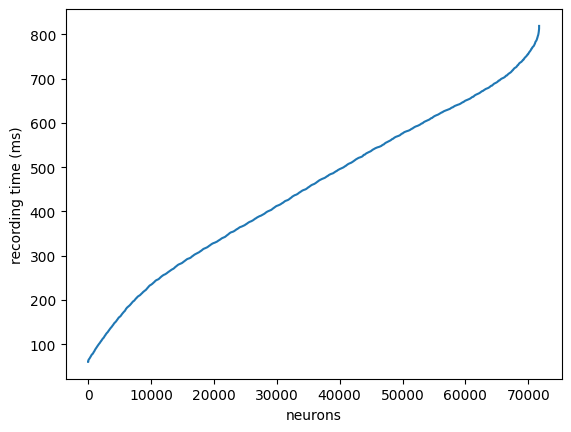

In [44]:
# What is the time stamp in ms of each neuron at t=0 in the zapbench data?
plt.plot(np.sort(ts_agg[0, :]))
plt.xlabel("neurons")
plt.ylabel("recording time (ms)")

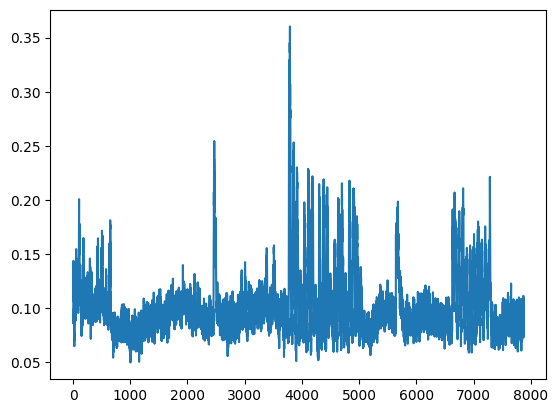

In [59]:
# find a cell with some sharp peaks
cell_ix = 100
plt.plot(traces_official[:, cell_ix])

In [ ]:
num_z_per_cell = np.bincount(cell_id)
_, start_index = np.unique(cell_id, return_index=True)
ixs = np.arange(start_index[cell_ix], start_index[cell_ix]+num_z_per_cell[cell_ix])
# indices of different z planes in flattened array of `cell_ix`
ixs

array([270, 271, 272, 273])

In [ ]:
# how many pixels are contained in each z
num_pxs[ixs]

array([ 21,  95, 102,  71], dtype=int32)

In [ ]:
cell_trace_agg = traces_agg[:, cell_ix]

((71721,), (71721,))

z=6: a=0.988, b=0.003
z=7: a=0.995, b=0.001
z=8: a=1.021, b=-0.002
z=9: a=0.980, b=0.000


Text(0.5, 1.0, 'cell_ix=100')

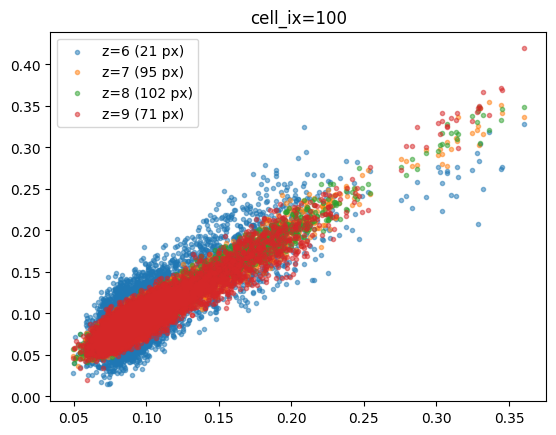

In [80]:
for i in ixs:
  p = plt.scatter(traces_agg[:, cell_ix], traces[:, i], marker=".", alpha=0.5, label=f"z={z_cell[i]} ({num_pxs[i]} px)")
  a, b = np.polyfit(traces_agg[:, cell_ix], traces[:, i], 1)
  print(f"z={z_cell[i]}: {a=:.3f}, {b=:.3f}")
plt.legend()
plt.title(f"{cell_ix=}")


## Interpolate

Here we interpolate the traces to align all recordings to the same time point.</br>
I don't think this is a good idea since it will smooth a peaky signal. But this
is just for illustration.

In [124]:
# this is the cell whose recording starts at the lowest wall time point
# we will linearly interpolate traces to match this cell
ref_time_cell = np.argmin(ts_agg[0])
ts_agg[:, ref_time_cell]


#chatgpt generated code
def align_traces_to_reference(values, times, ref_idx):
    """
    Linearly interpolate all traces (columns) to match the time points
    of the reference trace (column ref_idx). When interpolation is not
    possible, output NaN.

    Parameters
    ----------
    values : np.ndarray
        Array of shape (n_timepoints, n_traces).
    times : np.ndarray
        Array of shape (n_timepoints, n_traces) with time points for each trace.
    ref_idx : int
        Index of the reference trace (column) to align others to.

    Returns
    -------
    aligned : np.ndarray
        Array of shape (len(times), n_traces) with aligned traces.
    """
    ref_t = times[:, ref_idx]
    n_traces = values.shape[1]
    aligned = np.full((len(ref_t), n_traces), np.nan, dtype=np.float64)

    for j in range(n_traces):
        t = times[:, j]
        v = values[:, j]

        # Mask out NaNs or invalid points
        mask = np.isfinite(t) & np.isfinite(v)
        if np.count_nonzero(mask) < 2:
            continue  # Not enough points to interpolate

        # Ensure monotonic order (np.interp requires ascending x)
        order = np.argsort(t[mask])
        tt = t[mask][order]
        vv = v[mask][order]

        # Interpolate to reference times
        try:
            aligned[:, j] = np.interp(ref_t, tt, vv, left=np.nan, right=np.nan)
        except Exception:
            pass  # keep NaNs if interpolation fails

    return aligned

interp = align_traces_to_reference(traces_agg, ts_agg, ref_idx=ref_time_cell)

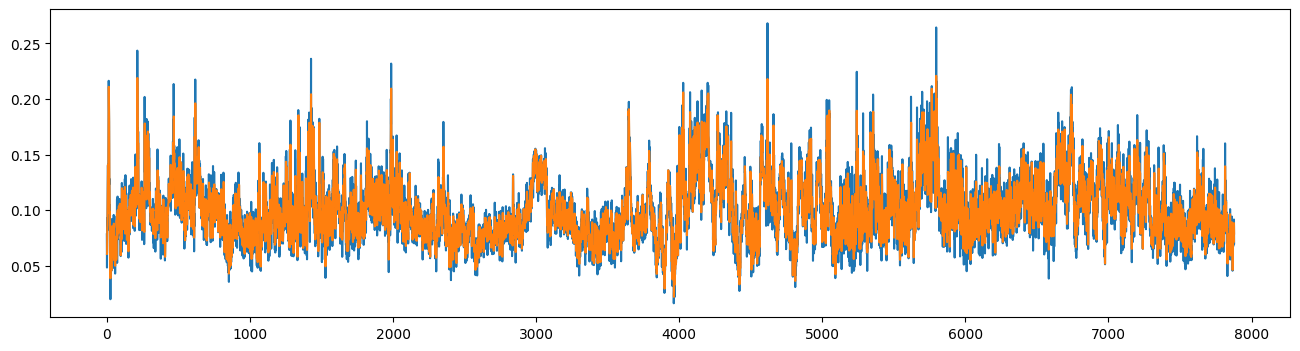

In [125]:
ix = 1000
plt.figure(figsize=(16, 4))
plt.plot(traces_official[:, ix])
# plt.plot(traces_agg[:, ix], marker="o")
plt.plot(interp[:, ix])
